# **Model and Evaluation**

## Objectives

* Develop an ML model that classifies leaf images into these two categories; healthy or containing powdery mildew (Business Requirement 2).

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings.

```plaintext
├── inputs
│ └── cherryleaves_dataset
│ └── cherry-leaves
│   ├── test
│   │ ├── healthy
│   │ └── powdery_mildew
│   ├── train
│   │ ├── healthy
│   │ └── powdery_mildew
│   └── validation
│   │ ├── healthy
│   │ └── powdery_mildew
└── ...
``` 

## Outputs

* Image distribution plot in train, validation, and test set
* Image augementation for each set
* Class indices to change prediction inference in labels
* Creation of an ML model
* Display ML model summary
* Train ML model
* Save ML model
* Create Learning Curve Plot for model performance
* Model Evaluation on pickle file; determine accuracy, plot ROC curve, and calculate classification report 
* Plot Confusion Matrix
* Prediction on the random image file


---

# Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set Input Directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images Distribution

These plots will give you a comprehensive view of your dataset's distribution across different labels and sets, which is essential for understanding data balance and preparing for model training.

## Count Number of Images per Set & Label

In [9]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




## Label Distribution - Bar Chart

In [10]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Cherry Leaves Dataset", 
            text_auto=True)
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'{file_path}/number_leaves_sets.png')

## Set Distribution

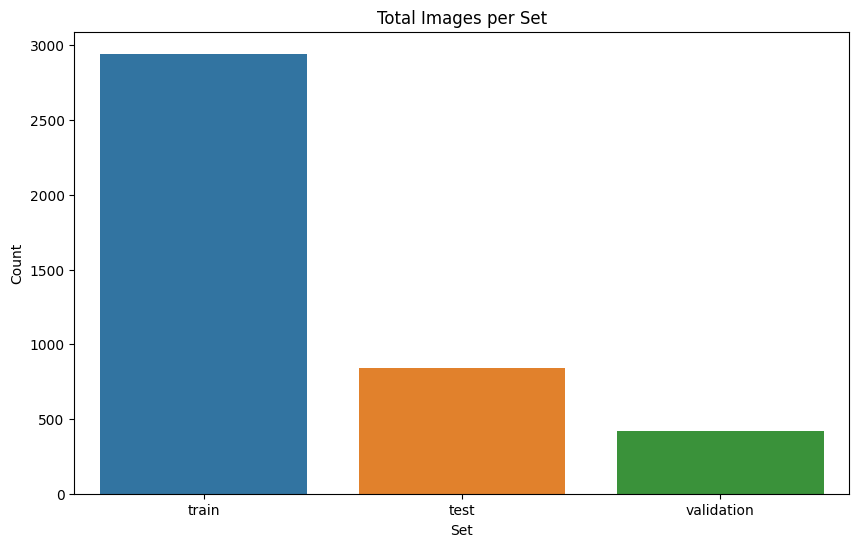

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Count', estimator=sum, ci=None)
plt.title('Total Images per Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.savefig(f'{file_path}/sets_distribution_bar.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation
---

## Import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Set Batch Size

In [14]:
batch_size = 18

## Augment Training Image Set

In [15]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Training Image Set

(18, 256, 256, 3)


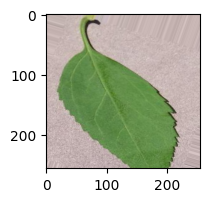

(18, 256, 256, 3)


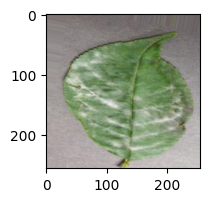

(18, 256, 256, 3)


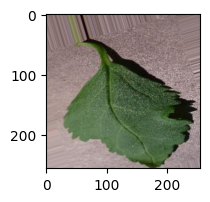

In [16]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment Validation Image Set

In [17]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Validation Image Set

(18, 256, 256, 3)


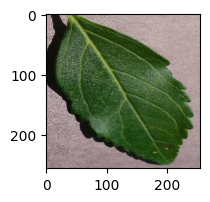

(18, 256, 256, 3)


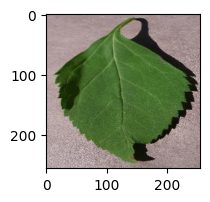

(18, 256, 256, 3)


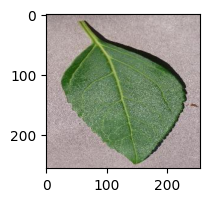

In [18]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment Test Image Set

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Test Image Set

(18, 256, 256, 3)


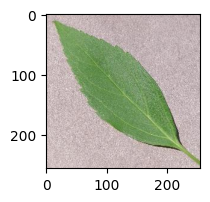

(18, 256, 256, 3)


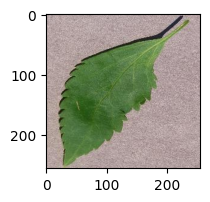

(18, 256, 256, 3)


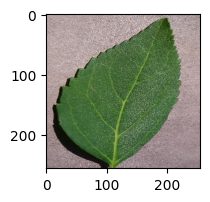

In [20]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model Creation

## Import Packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, Adagrad

## ML Model

In [23]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

## Model Summary

In [24]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-09-11 09:08:39.915969: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Callbacks
Callbacks are a powerful feature in machine learning, particularly when training models using libraries like TensorFlow and Keras. They provide a mechanism to control and customize the training process, allowing users to take specific actions at various stages of the training lifecycle.

### EarlyStopping & ModelCheckPoint
* EarlyStopping is used to monitor the val_accuracy (validation accuracy). 
* If the validation accuracy does not improve for a set number of epochs (patience=2 in your case), training will stop. 
* This prevents overfitting, where the model becomes too specialized on the training data and performs poorly on unseen data (like validation or test sets).
---
* ModelCheckPoint monitors the val_accuracy and saves the model with the highest validation accuracy to the file path specified (outputs/v1/powdery_mildew_model.h5)
* This ensures that you have a copy of the best-performing model, which is crucial if you want to avoid retraining the model from scratch or in case of any interruptions during training. 
* Saving only the best model also helps manage storage efficiently, especially if the training process runs for many epochs.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

## Fit Model for Model Training

In [29]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

Epoch 1/32
163/163 [==============================] - 203s 1s/step - loss: 0.5646 - accuracy: 0.7174 - val_loss: 0.3735 - val_accuracy: 0.8571
Epoch 2/32
163/163 [==============================] - 203s 1s/step - loss: 0.3643 - accuracy: 0.8472 - val_loss: 0.2746 - val_accuracy: 0.8810
Epoch 3/32
163/163 [==============================] - 202s 1s/step - loss: 0.2899 - accuracy: 0.8862 - val_loss: 0.2442 - val_accuracy: 0.8857
Epoch 4/32
163/163 [==============================] - 203s 1s/step - loss: 0.2402 - accuracy: 0.9070 - val_loss: 0.2018 - val_accuracy: 0.9119
Epoch 5/32
163/163 [==============================] - 203s 1s/step - loss: 0.2061 - accuracy: 0.9197 - val_loss: 0.2087 - val_accuracy: 0.9000
Epoch 6/32
163/163 [==============================] - 202s 1s/step - loss: 0.1776 - accuracy: 0.9354 - val_loss: 0.1947 - val_accuracy: 0.9119
Epoch 00006: early stopping


## Save model

In [30]:
model.save('outputs/v1/powdery_mildew_model.h5')

---

# Model Performance

## Model Learning Curve A - Training, Validation, Loss & Accuracy Over Epochs

<Figure size 500x400 with 0 Axes>

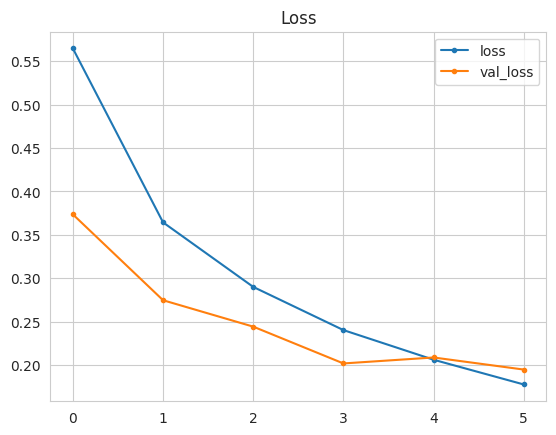

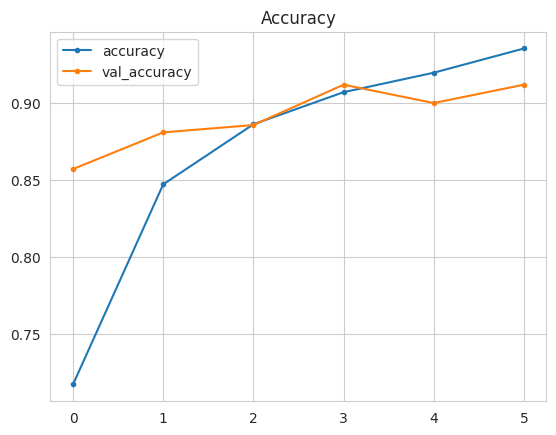

In [31]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Learning Curve B - Loss & Accuracy Over Training Epochs

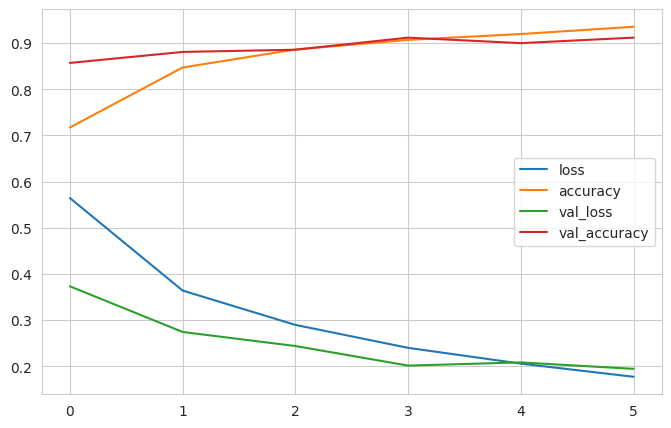

In [32]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve C - Loss & Accuracy Metrics of Model's Training Process Over Multiple Epochs

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=model.history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['loss'], name="loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter( y=model.history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )

fig.show()
fig.write_image(f'{file_path}/model_history.png')

---

# Model Evaluation

## Import Packages

In [34]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## Load Saved Model

In [35]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

## Evaluate Model Accuracy

In [36]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

47/47 [==============================] - 14s 304ms/step - loss: 0.1552 - accuracy: 0.9277
Model accuracy: 92.77%
Model Loss:  0.1552441567182541


## Set Accuracy Variables

In [37]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

## ROC Curve

Area Under ROC-Curve:  0.9277251184834123


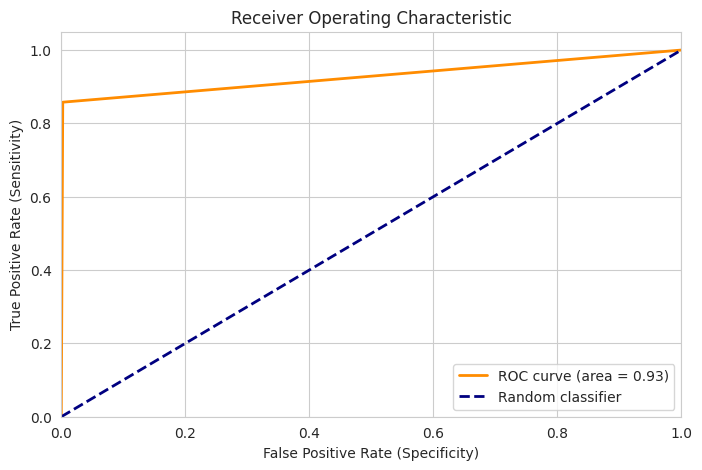

In [38]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")

fpr, tpr, _ = roc_curve(y_true, y_pred) # fpr: False Positive Rate, tpr: True Positive Rate
roc_auc = auc(fpr, tpr) # Calculate the Area Under the Curve (AUC) for the ROC curve

plt.figure(figsize=(8, 5))

lw = 2

plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('Receiver Operating Characteristic')

plt.legend(loc="lower right")

plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

## Confusion Matrix

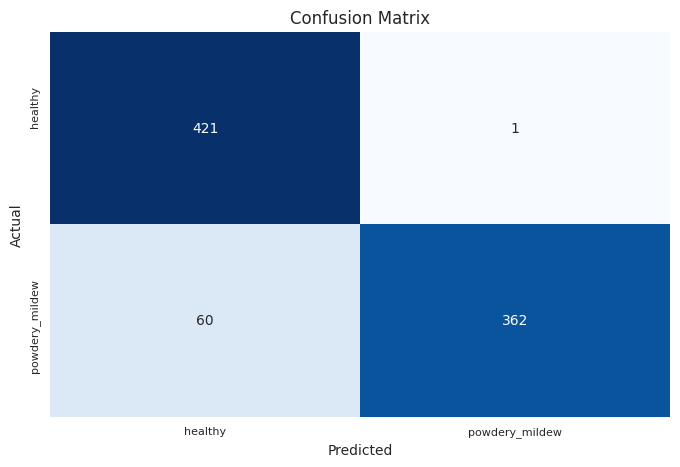

In [39]:
# Generate the confusion matrix based on the true and predicted labels
cm = confusion_matrix(y_true,y_pred)

# Retrieve the class names from the test set to label the axes of the confusion matrix
classes=list(test_set.class_indices.keys()) 

# Determine the number of classes
length=len(classes)

# Create a new figure for the confusion matrix plot with a specified figure size
plt.figure(figsize=(8, 5))

# Create a heatmap to visualise the confusion matrix
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# Set the tick marks for the x-axis
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)

# Set the tick marks for the y-axis
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)

plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Classification Report - A

In [40]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [41]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.88      1.00      0.93       422
powdery_mildew       1.00      0.86      0.92       422

      accuracy                           0.93       844
     macro avg       0.94      0.93      0.93       844
  weighted avg       0.94      0.93      0.93       844



## Classification Report - B

Text(0.5, 1.0, 'Classification Report')

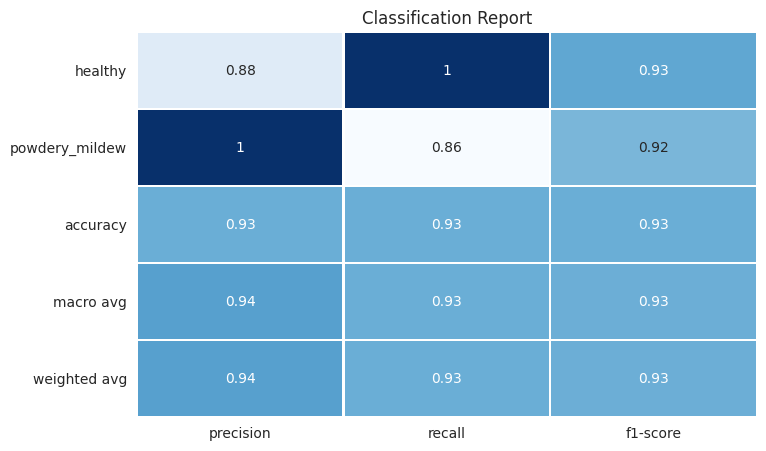

In [42]:
import matplotlib as mpl
clf_report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')

## Classification Report - C

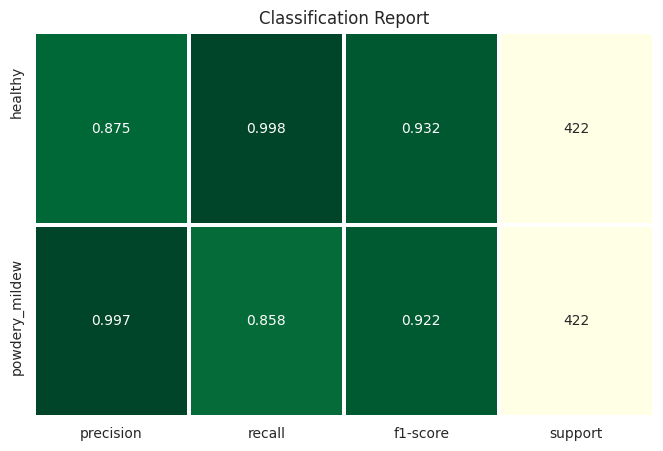

In [43]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
    fig, ax = plt.subplots(figsize=(8,5))    
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    df.sort_values(by=['support'], inplace=True) 
    
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True
 
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 
            
    plt.title(title)
    plt.yticks(np.arange(length)+.2, classes, rotation=90)
         
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax

fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

## Save Evaluation Pickle

In [44]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

# Predict On New Data

## Load Random Image as PIL

Image shape: (256, 256), Image mode: RGB


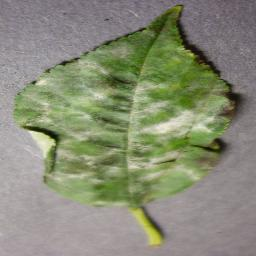

In [45]:
from tensorflow.keras.preprocessing import image

pointer = 76
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

## Convert Image To Array & Prepare for Prediction

In [46]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


## Predict Class Probabilities

In [47]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

powdery_mildew 98.44%


---